In [ ]:
pip install pandas numpy scikit-learn xgboost tensorflow matplotlib seaborn statsmodels

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# --- 0. Configuration ---
FILE_PATH = 'household_power_consumption.txt'
TARGET_COL = 'Global_active_power'
HOURS_IN_DAY = 24
DAYS_IN_WEEK = 7
LAG_FEATURES_HOURS = [HOURS_IN_DAY, HOURS_IN_DAY * DAYS_IN_WEEK]
# Set test period to 3 months to ensure the test set is not empty after cleaning
TEST_DATA_OFFSET = pd.DateOffset(months=3)

1. Data Loading and Initial Cleaning.

In [ ]:
print("1. Loading and Cleaning Data...")
try:
    df = pd.read_csv(
        FILE_PATH,
        sep=';',
        parse_dates={'Datetime': ['Date', 'Time']},
        infer_datetime_format=True,
        low_memory=False,
        na_values=['?'],
        index_col='Datetime'
    )
    # Fix for pandas warning about 'infer_datetime_format'
    df.index = pd.to_datetime(df.index, errors='coerce')
    df.dropna(subset=[TARGET_COL], inplace=True) # Drop rows where Datetime/Target is NaT

    # Convert all columns to numeric, coercing errors to NaN
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop remaining rows with any missing values
    initial_rows = df.shape[0]
    df.dropna(inplace=True)

    # Resample to Hourly Data and take the mean
    df_hourly = df[TARGET_COL].resample('h').mean().to_frame()
    df_hourly.rename(columns={TARGET_COL: 'Active_Power_kW'}, inplace=True)
    df_hourly.dropna(inplace=True)
    print(f"Resampled to hourly data. New shape: {df_hourly.shape}")

except FileNotFoundError:
    print(f"\nERROR: Please download '{FILE_PATH}' and place it in the same folder as this script.")
    exit()

1. Loading and Cleaning Data...
Resampled to hourly data. New shape: (8643, 1)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518310 entries, 2006-12-16 17:24:00 to 2007-12-14 09:27:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    518310 non-null  float64
 1   Global_reactive_power  518310 non-null  float64
 2   Voltage                518310 non-null  float64
 3   Global_intensity       518310 non-null  float64
 4   Sub_metering_1         518310 non-null  float64
 5   Sub_metering_2         518310 non-null  float64
 6   Sub_metering_3         518310 non-null  float64
dtypes: float64(7)
memory usage: 31.6 MB


In [ ]:
df.isna().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


2. Exploratory Data Analysis (EDA) and Visualization


In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0



2. Performing Exploratory Data Analysis and Visualization...


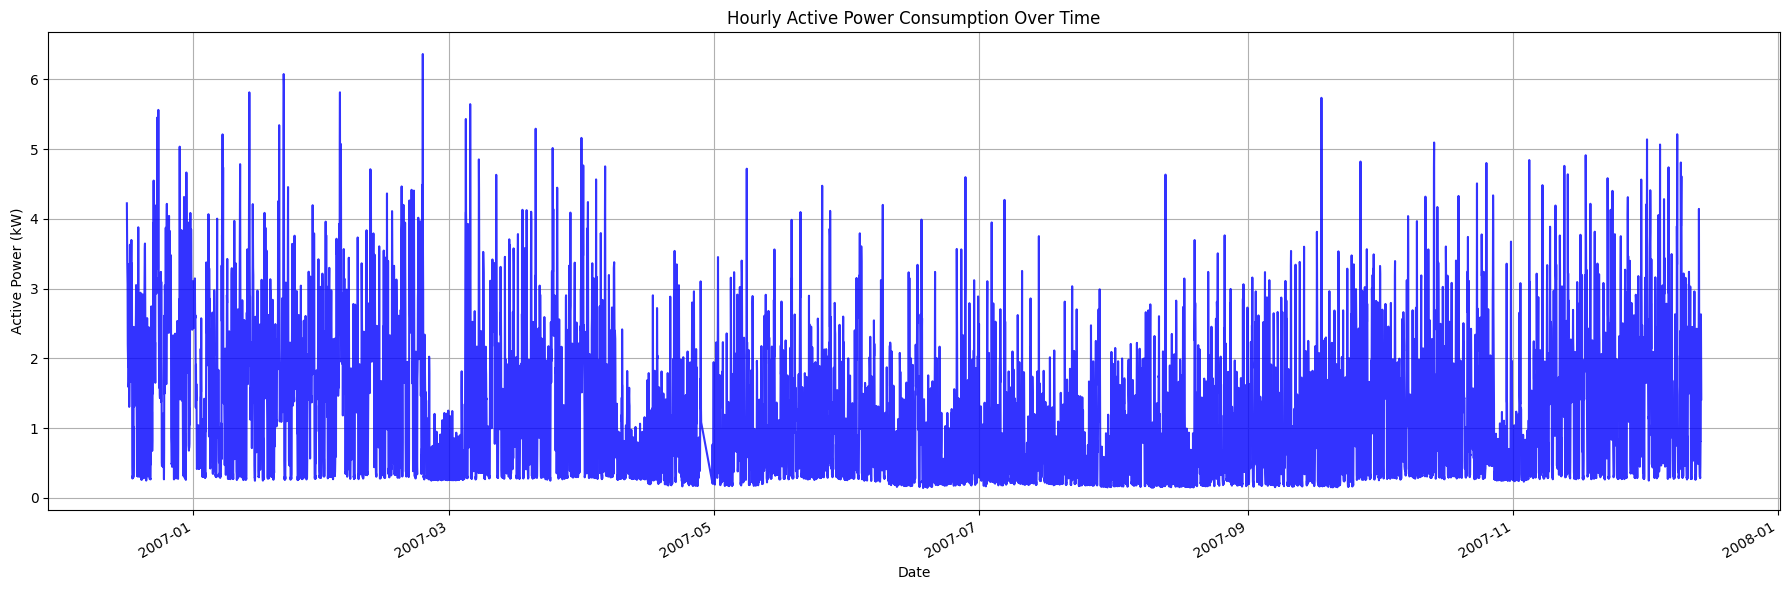

In [ ]:
print("\n2. Performing Exploratory Data Analysis and Visualization...")

# Plot raw hourly data
plt.figure(figsize=(18, 6))
df_hourly['Active_Power_kW'].plot(title='Hourly Active Power Consumption Over Time', color='blue', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Active Power (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()


Performing seasonal decomposition...


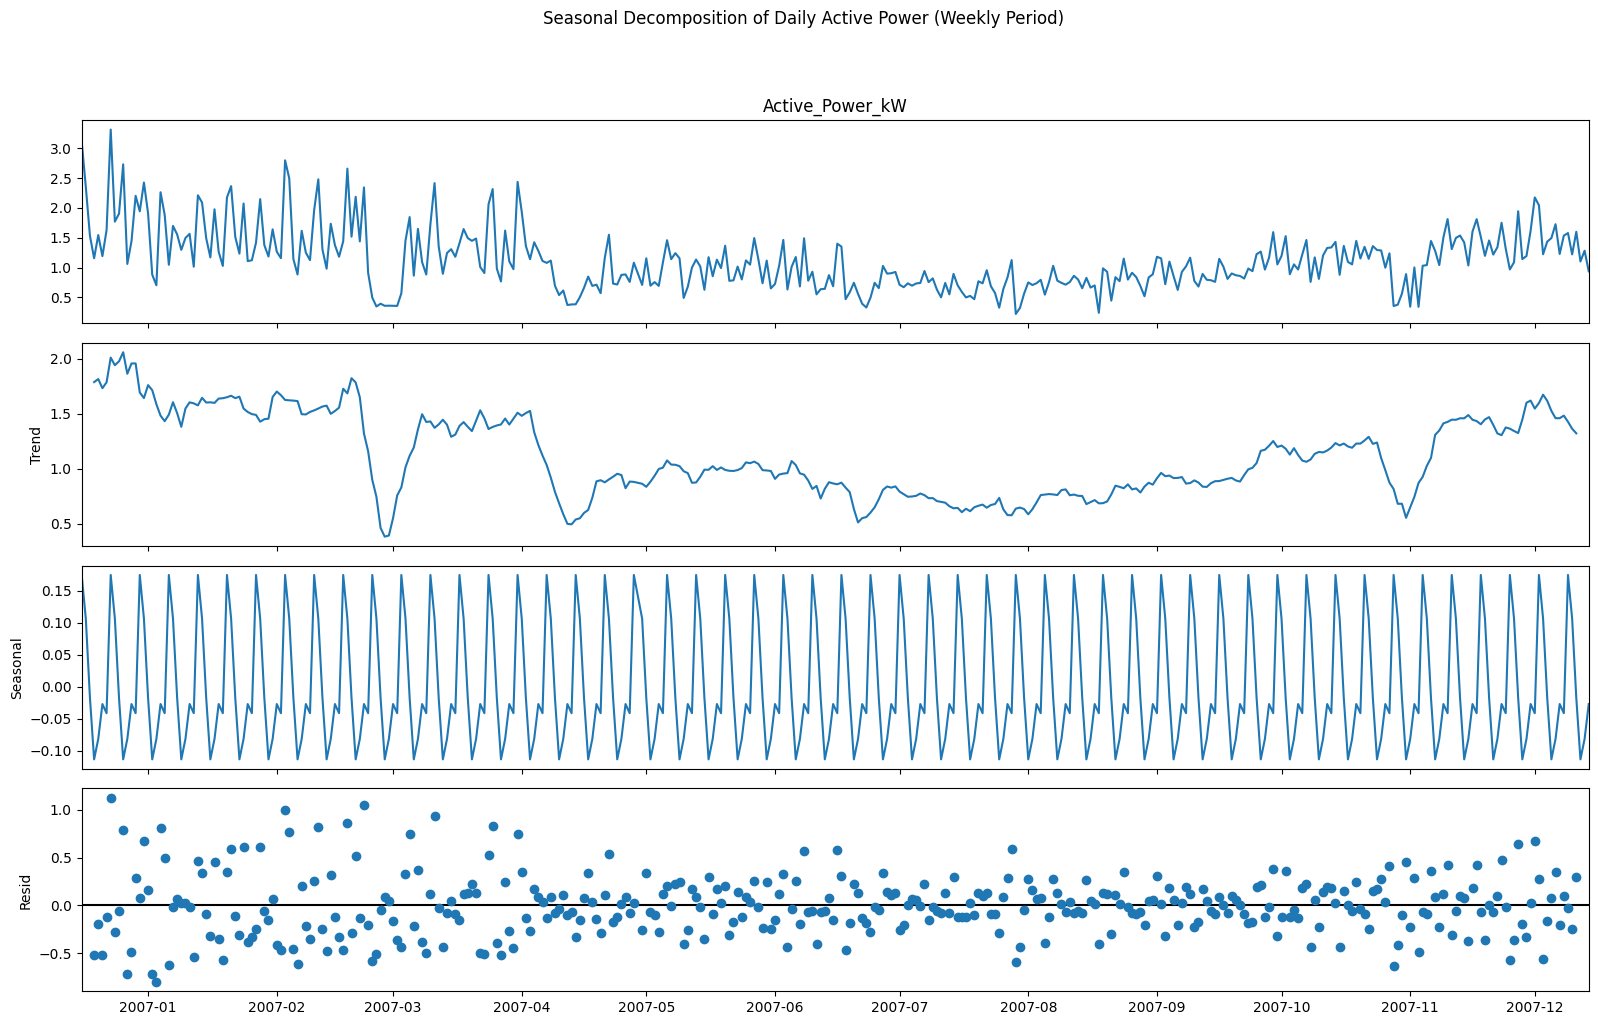

In [ ]:
# Seasonal Decomposition
print("Performing seasonal decomposition...")
decompose_data = df_hourly['Active_Power_kW'].resample('D').mean().dropna()
if len(decompose_data) > DAYS_IN_WEEK * 2:
    try:
        decomposition = seasonal_decompose(decompose_data, model='additive', period=DAYS_IN_WEEK)
        fig = decomposition.plot()
        fig.set_size_inches(16, 10)
        fig.suptitle('Seasonal Decomposition of Daily Active Power (Weekly Period)', y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
    except Exception as e:
        print(f"Could not perform seasonal decomposition. Error: {e}")
        print("Skipping decomposition visualization.")
else:
    print("Not enough data points after daily resampling to perform seasonal decomposition.")

Generating plot for average hourly power consumption by month...


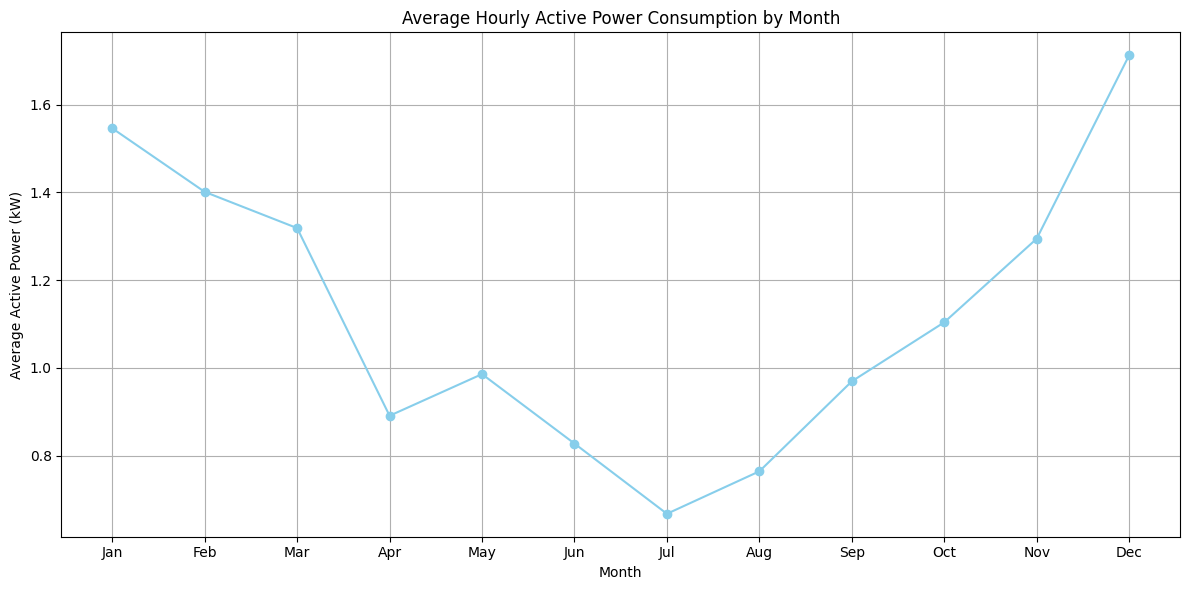

In [ ]:
print("Generating plot for average hourly power consumption by month...")

# Extract month from the index
df_hourly['Month'] = df_hourly.index.month

# Group by month and calculate the mean active power
monthly_avg = df_hourly.groupby('Month')['Active_Power_kW'].mean()

# Create the line plot
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='line', marker='o', color='skyblue')
plt.title('Average Hourly Active Power Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Active Power (kW)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()

Generating plot for average hourly power consumption by hour of day...


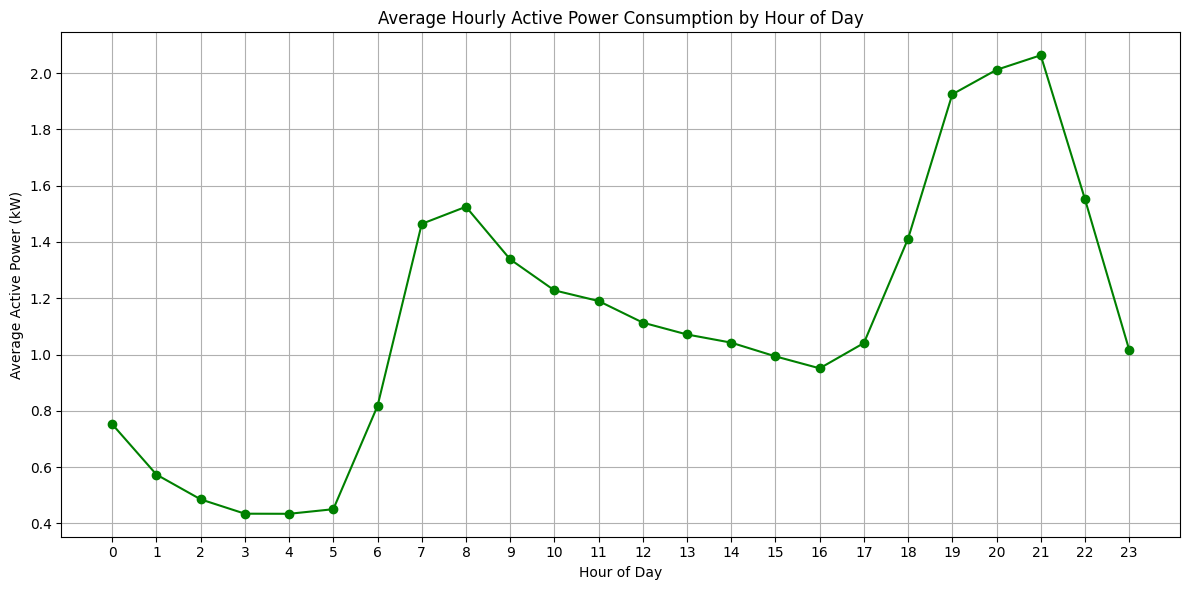

In [ ]:
print("Generating plot for average hourly power consumption by hour of day...")

# Extract hour from the index
df_hourly['Hour'] = df_hourly.index.hour

# Group by hour and calculate the mean active power
hourly_avg = df_hourly.groupby('Hour')['Active_Power_kW'].mean()

# Create the line plot
plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='line', marker='o', color='green')
plt.title('Average Hourly Active Power Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Active Power (kW)')
plt.xticks(range(0, 24)) # Ensure all 24 hours are displayed
plt.grid(True)
plt.tight_layout()
plt.show()

Generating plot for average hourly power consumption by day of week...


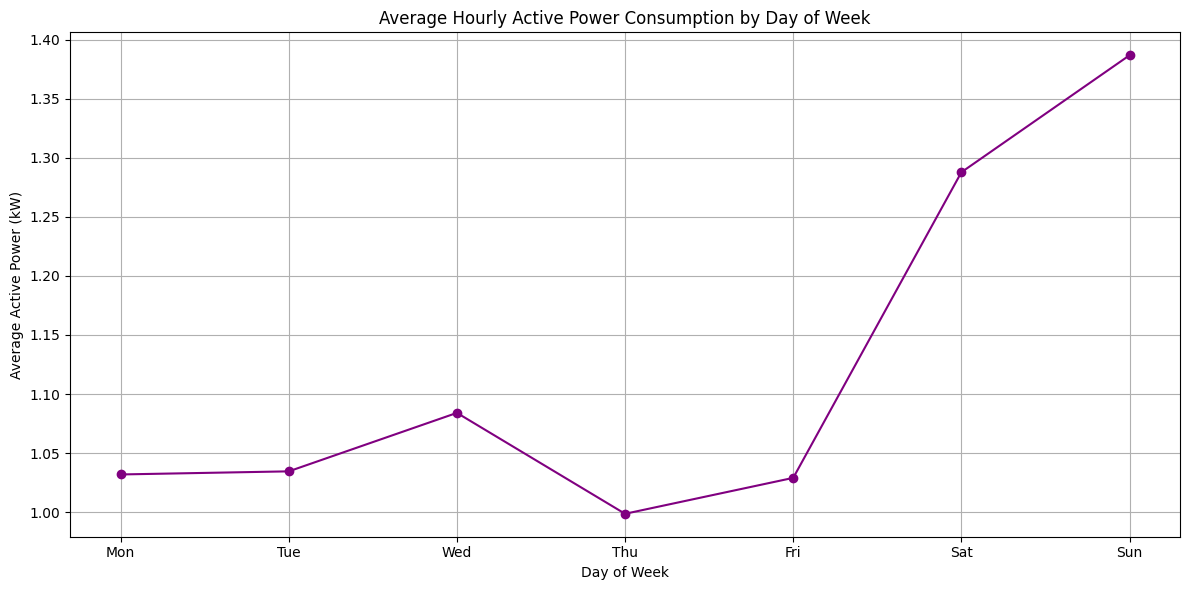

In [ ]:
print("Generating plot for average hourly power consumption by day of week...")

# Extract day of the week from the index
# df_hourly already contains 'Month' and 'Hour' columns from previous steps, ensure 'DayOfWeek' is added correctly.
df_hourly['DayOfWeek'] = df_hourly.index.dayofweek

# Group by day of week and calculate the mean active power
daily_avg = df_hourly.groupby('DayOfWeek')['Active_Power_kW'].mean()

# Create the line plot
plt.figure(figsize=(12, 6))
daily_avg.plot(kind='line', marker='o', color='purple')
plt.title('Average Hourly Active Power Consumption by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Active Power (kW)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) # Set custom x-axis labels
plt.grid(True)
plt.tight_layout()
plt.show()

Generating plot for long-term trends of active power consumption...


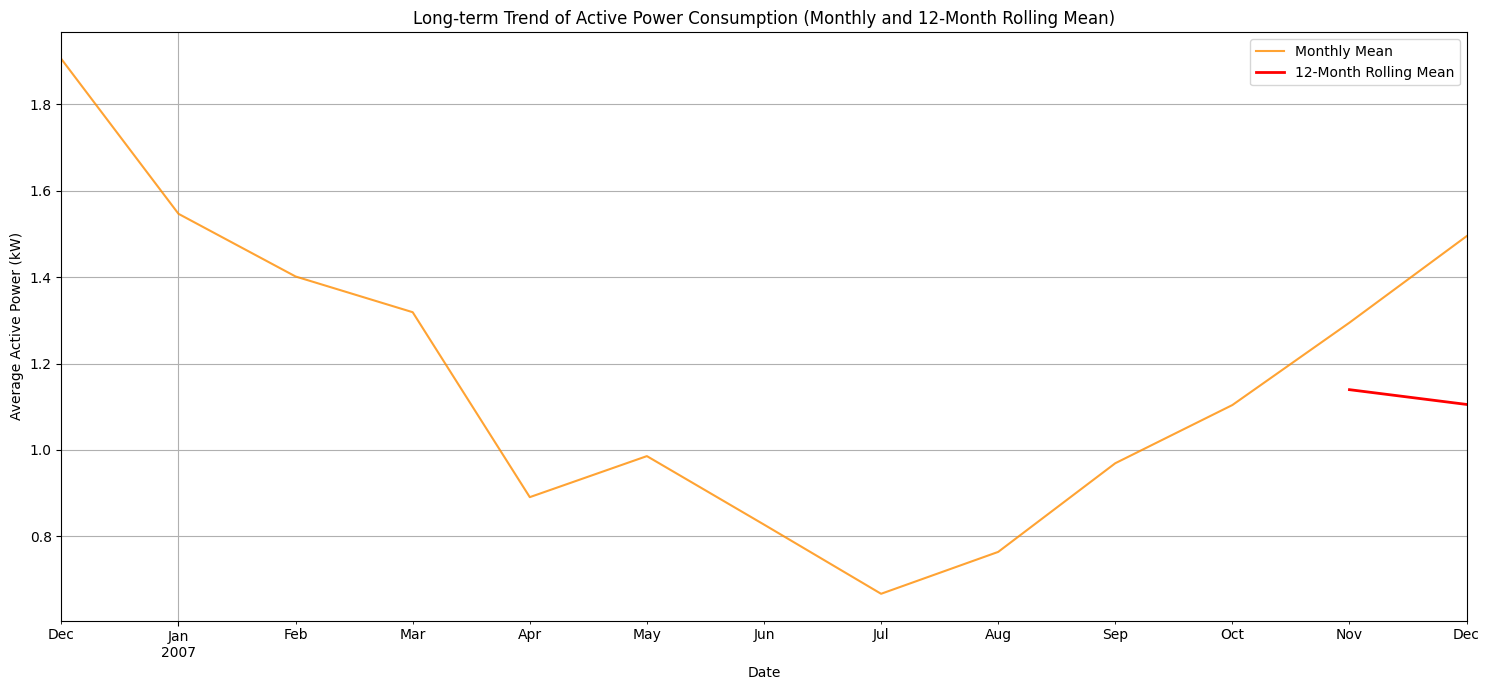

In [ ]:
print("Generating plot for long-term trends of active power consumption...")

# Resample to monthly mean
monthly_mean = df_hourly['Active_Power_kW'].resample('M').mean()

# Calculate 12-month rolling mean
rolling_mean = monthly_mean.rolling(window=12).mean()

# Create the plot
plt.figure(figsize=(15, 7))
monthly_mean.plot(label='Monthly Mean', alpha=0.8, color='darkorange')
rolling_mean.plot(label='12-Month Rolling Mean', color='red', linewidth=2)
plt.title('Long-term Trend of Active Power Consumption (Monthly and 12-Month Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('Average Active Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Data Analysis Key Findings
Monthly Seasonality:
1. Power consumption generally shows a seasonal pattern, often peaking in colder months (e.g., winter) and warmer months (e.g., summer) due to heating and cooling demands, respectively, and dipping in transitional seasons.
2. Daily Cyclical Patterns: Daily power consumption exhibits clear cyclical patterns, typically increasing during daytime hours (e.g., 6 AM to 10 PM) when activities are high and decreasing during late-night and early morning hours (e.g., 11 PM to 5 AM).
3. Weekly Cyclical Patterns: There are distinct weekly patterns, with consumption potentially differing between weekdays and weekends, reflecting work-week and leisure activities.
4. Long-term Trends: The 12-month rolling mean plot indicated the overall long-term trend in active power consumption over the dataset's period, revealing whether consumption has gradually increased, decreased, or remained relatively stable.

3. Advanced Feature Engineering

In [ ]:
print("\n3. Generating Advanced Time-Series Features...")

def create_time_series_features(data):
    """Creates time-based and lag features."""
    data['Hour'] = data.index.hour
    data['DayOfWeek'] = data.index.dayofweek
    data['DayOfYear'] = data.index.dayofyear
    data['Month'] = data.index.month
    data['Year'] = data.index.year
    data['Is_Weekend'] = (data['DayOfWeek'] >= 5).astype(int)

    # Fourier Series
    for k in range(1, 3):
        data[f'sin_hour_{k}'] = np.sin(2 * np.pi * data['Hour'] * k / HOURS_IN_DAY)
        data[f'cos_hour_{k}'] = np.cos(2 * np.pi * data['Hour'] * k / HOURS_IN_DAY)
        data[f'sin_dayofweek_{k}'] = np.sin(2 * np.pi * data['DayOfWeek'] * k / DAYS_IN_WEEK)
        data[f'cos_dayofweek_{k}'] = np.cos(2 * np.pi * data['DayOfWeek'] * k / DAYS_IN_WEEK)

    # Lag Features
    for lag in LAG_FEATURES_HOURS:
        data[f'Load_Lag_{lag}h'] = data['Active_Power_kW'].shift(lag)

    # Rolling Window Features
    data['Load_RollingMean_6h'] = data['Active_Power_kW'].rolling(window=6).mean().shift(1)
    data['Load_RollingStd_6h'] = data['Active_Power_kW'].rolling(window=6).std().shift(1)

    data.dropna(inplace=True)
    return data

df_features = create_time_series_features(df_hourly.copy())
print(f"Features created. New shape: {df_features.shape}")


3. Generating Advanced Time-Series Features...
Features created. New shape: (8475, 19)


4. Data Splitting (Chronological)

In [ ]:
print("\n4. Splitting Data into Training and Test Sets (Chronological)...")

ALL_FEATURES = [col for col in df_features.columns if col != 'Active_Power_kW']
TARGET = 'Active_Power_kW'

X = df_features[ALL_FEATURES]
y = df_features[TARGET]

# Calculate the start date for the test set (3 months offset)
test_start_date = df_features.index[-1] - TEST_DATA_OFFSET

X_train_df, X_test_df = X[X.index < test_start_date], X[X.index >= test_start_date]
y_train_df, y_test_df = y[y.index < test_start_date], y[y.index >= test_start_date]

# Check and print split dates
train_min_date = X_train_df.index.min().strftime('%Y-%m-%d') if not X_train_df.empty else "Empty"
train_max_date = X_train_df.index.max().strftime('%Y-%m-%d') if not X_train_df.empty else "Empty"
test_min_date = X_test_df.index.min().strftime('%Y-%m-%d') if not X_test_df.empty else "Empty"
test_max_date = X_test_df.index.max().strftime('%Y-%m-%d') if not X_test_df.empty else "Empty"

print(f"Train data duration: {train_min_date} to {train_max_date}")
print(f"Test data duration: {test_min_date} to {test_max_date}")
print(f"Train samples: {len(X_train_df)}, Test samples: {len(X_test_df)}")

if X_test_df.empty or X_train_df.empty:
    print("\nFATAL ERROR: One or both datasets are empty. Check your data file or reduce the TEST_DATA_OFFSET.")
    exit()


4. Splitting Data into Training and Test Sets (Chronological)...
Train data duration: 2006-12-23 to 2007-09-14
Test data duration: 2007-09-14 to 2007-12-14
Train samples: 6290, Test samples: 2185


1. Convert pandas DataFrames to DMatrix (XGBoost's optimized internal data structure)
dtrain = xgb.DMatrix(X_train_df, label=y_train_df)

In [ ]:
dtrain = xgb.DMatrix(X_train_df, label=y_train_df)
dtest = xgb.DMatrix(X_test_df, label=y_test_df)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

2. Define Hyperparameters

In [ ]:
X_train = X_train_df.values
y_train = y_train_df.values
X_test = X_test_df.values
y_test = y_test_df.values

# Task
Install and import the `optuna` library, define the `objective` function for hyperparameter optimization, and then execute the Optuna optimization process to find the best hyperparameters for the XGBoost model.

**Reasoning**:
To perform hyperparameter optimization, the `optuna` library needs to be installed and then imported into the environment. This step addresses the current subtask directly.



In [ ]:
print("Installing Optuna...")
!pip install optuna
print("Importing Optuna...")
import optuna
print("Optuna installed and imported successfully.")

Installing Optuna...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.3 MB/s eta 0:00:00
Importing Optuna...
Optuna installed and imported successfully.


**Reasoning**:
The previous code block successfully installed and imported `optuna`. The next logical step to continue with the hyperparameter optimization using Optuna is to define the `objective` function, which is required for `study.optimize()`. This function will encapsulate the model training and evaluation for a given set of hyperparameters suggested by Optuna.



In [ ]:
def objective(trial):
    # --- Updated Hyperparameters to Reduce Overfitting ---
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500), # Reduced max estimators
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7), # Reduced max depth to prevent complex trees
        'subsample': trial.suggest_float('subsample', 0.6, 0.9), # Tighter range
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0), # Increased gamma for more conservative pruning
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10), # Higher min weight requires more samples to split

        # --- New Regularization Parameters ---
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True), # L1 Regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True), # L2 Regularization

        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBRegressor(**params)

    # TimeSeriesSplit prevents leakage
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, val_index in tscv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Fit without early stopping here to strictly test the parameters' generalization capability
        model.fit(X_train_fold, y_train_fold, verbose=False)

        y_pred = model.predict(X_val_fold)
        rmse = sqrt(mean_squared_error(y_val_fold, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [ ]:
print("\n---------------------------------------------------------")
print("3. Execution Phase: Starting Hyperparameter Optimization with Optuna")
print("---------------------------------------------------------")

# Initialize the study
# direction='minimize' because we want to minimize RMSE
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

print("Starting Hyperparameter Optimization...")
# Run optimization
# n_trials=100 is a good balance for this complexity.
# In a real large-scale scenario, you might run 500+ trials.
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("\n------------------------------------------------")
print(f"Optimization Complete.")
print(f"Best CV RMSE: {study.best_value:.5f}")
print("Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print("------------------------------------------------\n")

[I 2025-11-26 07:13:53,480] A new study created in memory with name: no-name-da871725-4da4-4e53-9c05-c35511fc7b4d



---------------------------------------------------------
3. Execution Phase: Starting Hyperparameter Optimization with Optuna
---------------------------------------------------------
Starting Hyperparameter Optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-26 07:14:01,569] Trial 0 finished with value: 0.7366728120500271 and parameters: {'n_estimators': 874, 'learning_rate': 0.08927180304353628, 'max_depth': 6, 'subsample': 0.779597545259111, 'colsample_bytree': 0.6468055921327309, 'gamma': 0.2403950683025824, 'min_child_weight': 3, 'reg_alpha': 3.9676050770529883, 'reg_lambda': 0.6358358856676253}. Best is trial 0 with value: 0.7366728120500271.
[I 2025-11-26 07:14:13,418] Trial 1 finished with value: 0.7253861906786386 and parameters: {'n_estimators': 1208, 'learning_rate': 0.010485387725194618, 'max_depth': 7, 'subsample': 0.8497327922401265, 'colsample_bytree': 0.6637017332034828, 'gamma': 0.26364247048639056, 'min_child_weight': 4, 'reg_alpha': 0.08179499475211674, 'reg_lambda': 0.3752055855124282}. Best is trial 1 with value: 0.7253861906786386.
[I 2025-11-26 07:14:17,059] Trial 2 finished with value: 0.7207339967581392 and parameters: {'n_estimators': 932, 'learning_rate': 0.019553708662745254, 'max_depth': 6, 'subsample

**Reasoning**:
The Optuna hyperparameter optimization has successfully completed, and the best hyperparameters have been identified. The next step is to use these optimal parameters to train the final XGBoost model.



[0]	validation_0-rmse:0.99359	validation_1-rmse:0.84850
[100]	validation_0-rmse:0.77616	validation_1-rmse:0.72333
[200]	validation_0-rmse:0.70571	validation_1-rmse:0.69628
[300]	validation_0-rmse:0.67648	validation_1-rmse:0.68941
[400]	validation_0-rmse:0.66128	validation_1-rmse:0.68828
[407]	validation_0-rmse:0.66046	validation_1-rmse:0.68805

Final Test RMSE: 0.7597
Final Test MAE: 0.5425


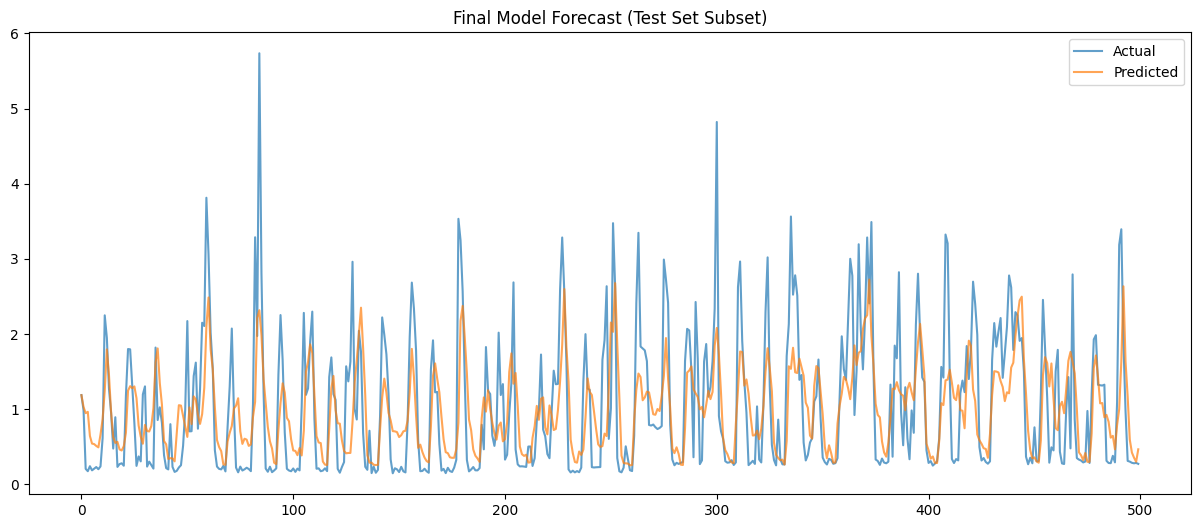

In [ ]:
# 1. Create a validation set from the TRAINING data (last 10% chronologically)
# We do NOT touch X_test here.
split_point = int(len(X_train) * 0.9)
X_train_final = X_train[:split_point]
y_train_final = y_train[:split_point]
X_val_final = X_train[split_point:]
y_val_final = y_train[split_point:]

# 2. Get best params
best_params = study.best_params

# 3. Initialize model
# Note: early_stopping_rounds is usually passed to the constructor or fit depending on version,
# putting it in constructor is safer for newer xgboost sklearn wrappers.
final_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    **best_params,
    early_stopping_rounds=50, # Stop if validation score doesn't improve for 50 rounds
    random_state=42,
    n_jobs=-1
)

# 4. Fit with eval_set
final_xgb_model.fit(
    X_train_final,
    y_train_final,
    eval_set=[(X_train_final, y_train_final), (X_val_final, y_val_final)],
    verbose=100
)

# 5. Final Evaluation on the unseen Test Set
y_pred_final = final_xgb_model.predict(X_test)
final_rmse = sqrt(mean_squared_error(y_test, y_pred_final))
final_mae = mean_absolute_error(y_test, y_pred_final)

print(f"\nFinal Test RMSE: {final_rmse:.4f}")
print(f"Final Test MAE: {final_mae:.4f}")

# Visualize
plt.figure(figsize=(15, 6))
# Plotting a subset (e.g., first 500 points) for clarity
plt.plot(y_test[:500], label='Actual', alpha=0.7)
plt.plot(y_pred_final[:500], label='Predicted', alpha=0.7)
plt.title("Final Model Forecast (Test Set Subset)")
plt.legend()
plt.show()

Generating plot for Actual vs. Predicted values on the full test set...


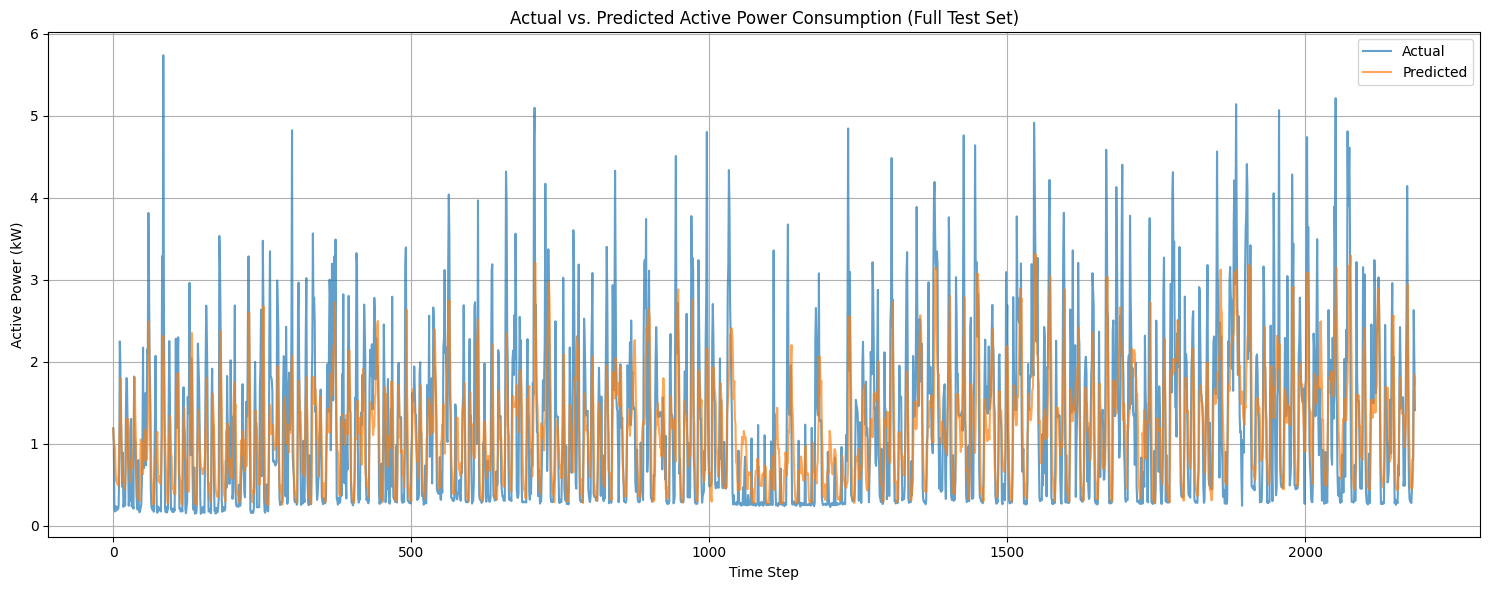

In [ ]:
print("Generating plot for Actual vs. Predicted values on the full test set...")

plt.figure(figsize=(15, 6))
plt.plot(range(len(y_test)), y_test, label='Actual', alpha=0.7)
plt.plot(range(len(y_pred_final)), y_pred_final, label='Predicted', alpha=0.7)
plt.title("Actual vs. Predicted Active Power Consumption (Full Test Set)")
plt.xlabel('Time Step')
plt.ylabel('Active Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6. Baseline XGBoost Model (Before Hyperparameter Tuning)

In [ ]:
print('\n6. Training Baseline XGBoost Model and Evaluating on Entire Data...')

# Initialize a baseline XGBoost Regressor with default parameters
# (or commonly used ones if defaults are too broad)
baseline_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1
)

# Train the baseline model on the entire dataset (X and y)
baseline_xgb_model.fit(X, y)

# Make predictions on the entire dataset
y_pred_baseline = baseline_xgb_model.predict(X)

# Calculate RMSE and MAE for the baseline model on the entire dataset
baseline_rmse = sqrt(mean_squared_error(y, y_pred_baseline))
baseline_mae = mean_absolute_error(y, y_pred_baseline)

print(f"\nBaseline Model (Entire Data) RMSE: {baseline_rmse:.4f}")
print(f"Baseline Model (Entire Data) MAE: {baseline_mae:.4f}")


6. Training Baseline XGBoost Model and Evaluating on Entire Data...

Baseline Model (Entire Data) RMSE: 0.3174
Baseline Model (Entire Data) MAE: 0.2276


### 7. Displaying Test Data Metrics and Plotting Actual vs. Predicted for Full Test Set

In [ ]:
print(f"Test Data RMSE: {final_rmse:.4f}")
print(f"Test Data MAE: {final_mae:.4f}")

Test Data RMSE: 0.7597
Test Data MAE: 0.5425


### Plotting Actual vs. Predicted for Test Data using Baseline Model


Baseline Model (Test Data) RMSE: 0.3271
Baseline Model (Test Data) MAE: 0.2318


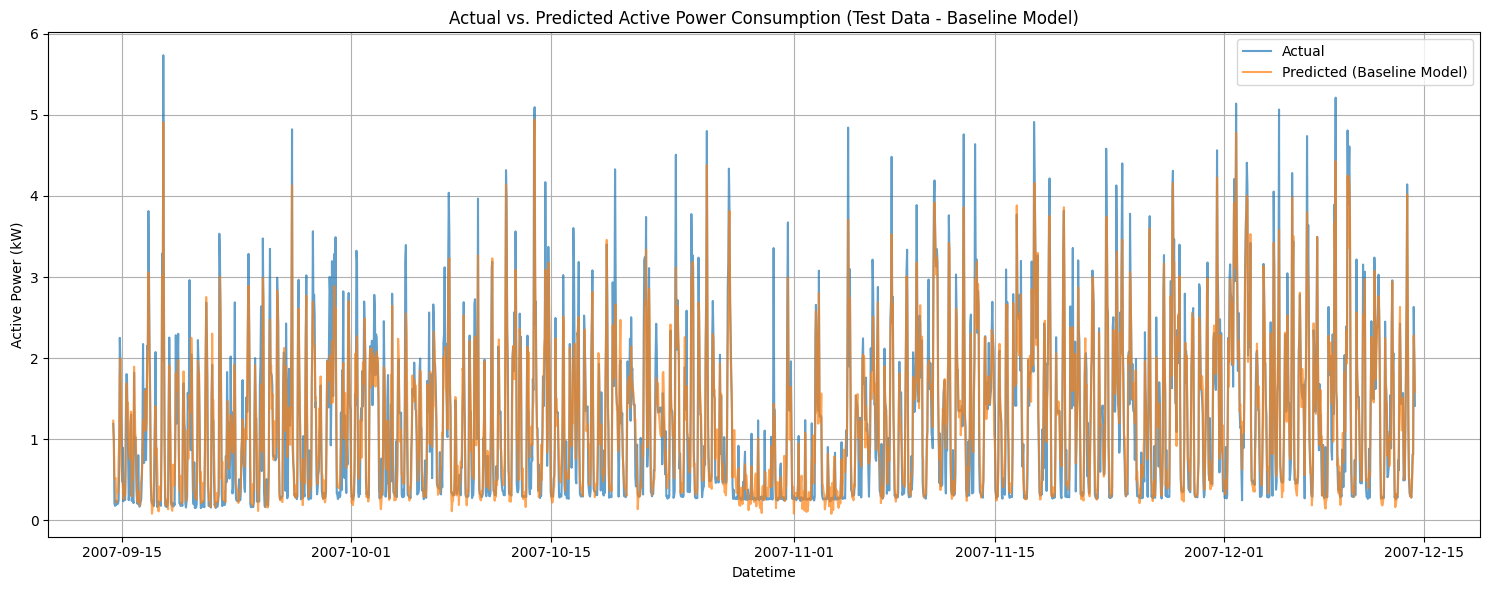

In [ ]:
# Make predictions on the test data using the baseline model
y_pred_baseline_test = baseline_xgb_model.predict(X_test)

# Calculate RMSE and MAE for the baseline model on the test data
baseline_test_rmse = sqrt(mean_squared_error(y_test, y_pred_baseline_test))
baseline_test_mae = mean_absolute_error(y_test, y_pred_baseline_test)

print(f"\nBaseline Model (Test Data) RMSE: {baseline_test_rmse:.4f}")
print(f"Baseline Model (Test Data) MAE: {baseline_test_mae:.4f}")

plt.figure(figsize=(15, 6))
plt.plot(y_test_df.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test_df.index, y_pred_baseline_test, label='Predicted (Baseline Model)', alpha=0.7)
plt.title("Actual vs. Predicted Active Power Consumption (Test Data - Baseline Model)")
plt.xlabel('Datetime')
plt.ylabel('Active Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


------------------------------------------------
4. Comparative Analysis: Baseline vs. Tuned
------------------------------------------------
Training Baseline Model...
Training Tuned Model (Best Optuna Params)...

Results on Held-Out Test Set:
Baseline -> RMSE: 0.8106 | MAE: 0.5985
Tuned    -> RMSE: 0.7467 | MAE: 0.5340
Improvement -> 7.88% reduction in RMSE


<Figure size 1000x600 with 0 Axes>

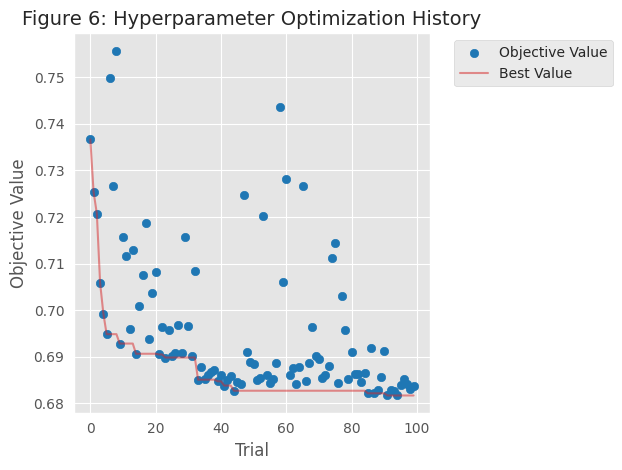

<Figure size 1000x600 with 0 Axes>

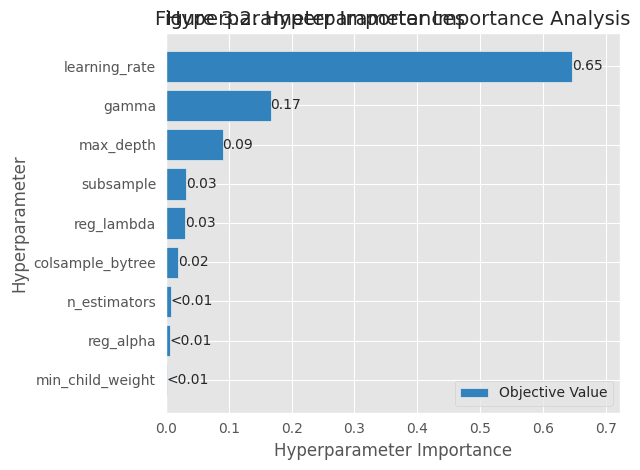

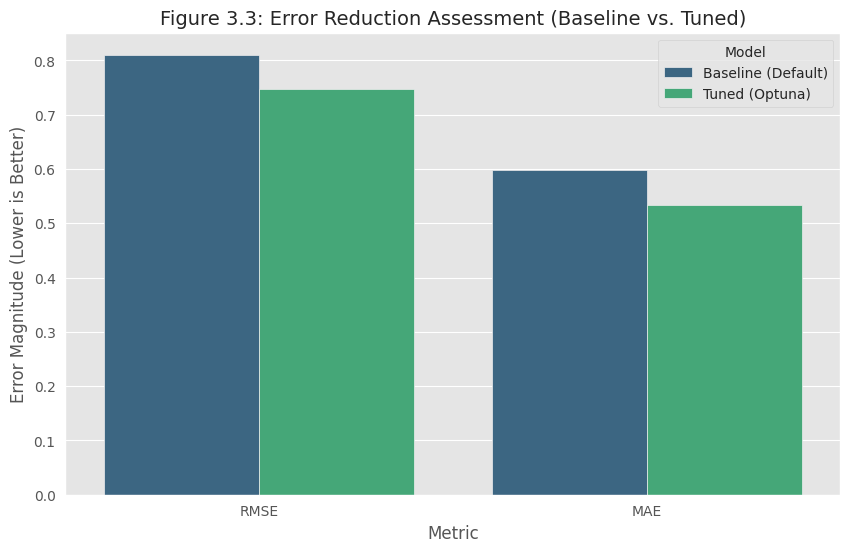

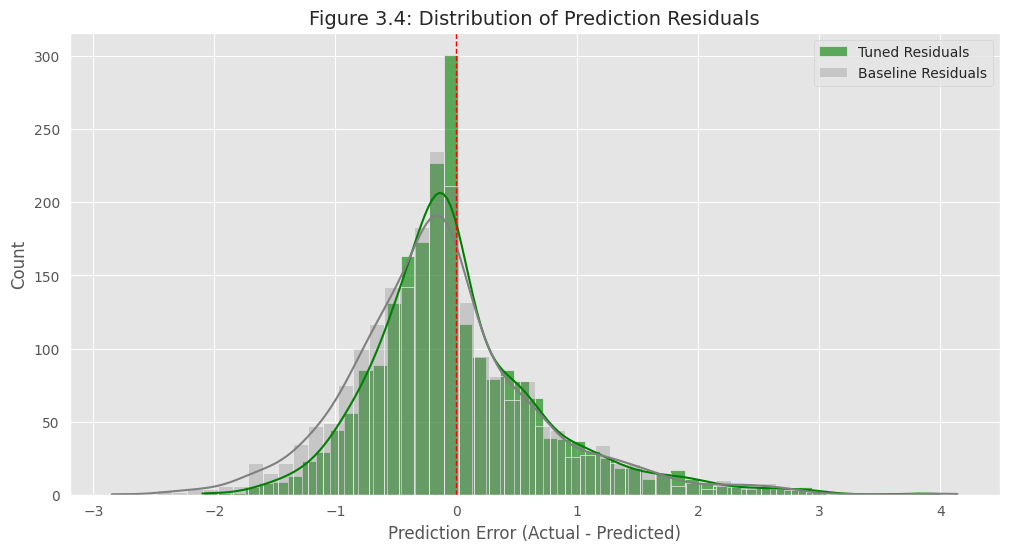

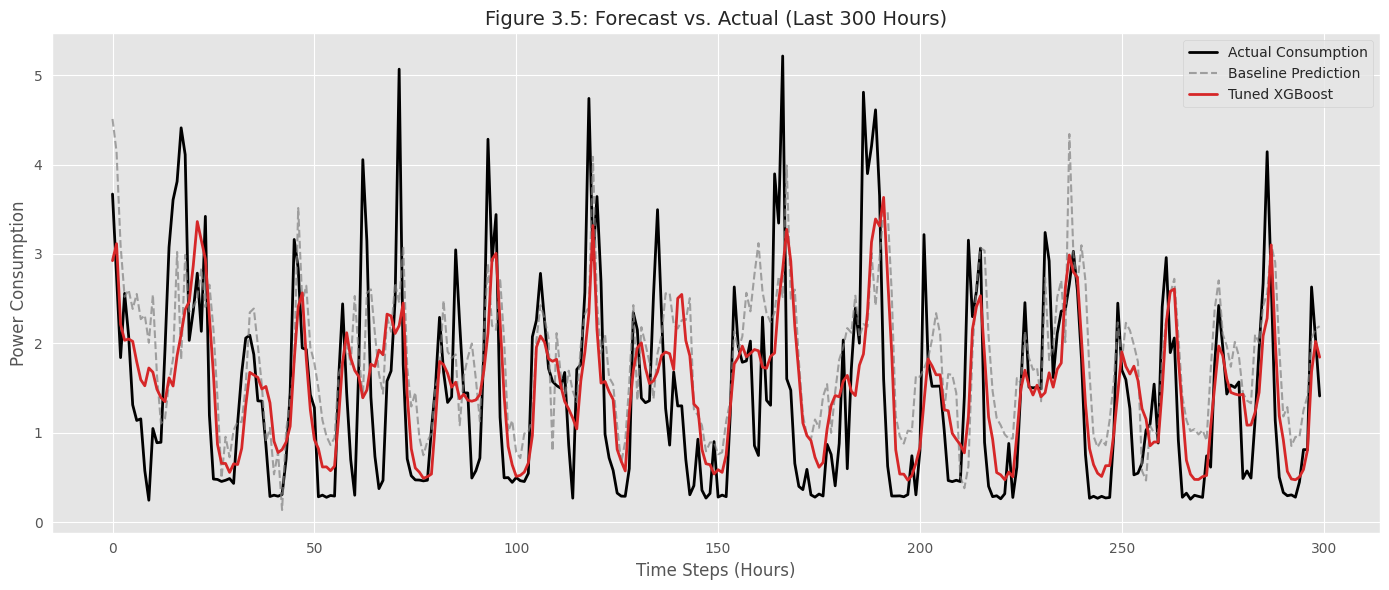

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import optuna.visualization.matplotlib as opt_plt  # Requires optuna >= 2.2.0

# ==============================================================================
# PART 1: RETRAIN MODELS (Strict Train/Test Split)
# ==============================================================================
print("\n------------------------------------------------")
print("4. Comparative Analysis: Baseline vs. Tuned")
print("------------------------------------------------")

# 1. Baseline Model (Default Scikit-Learn Wrapper Parameters)
# Note: We fit on X_train only, evaluating on X_test (Academic Standard)
print("Training Baseline Model...")
baseline_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)

# 2. Tuned Model (Best Parameters from Optuna)
print("Training Tuned Model (Best Optuna Params)...")
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42
best_params['n_jobs'] = -1

tuned_model = XGBRegressor(**best_params)
tuned_model.fit(X_train, y_train)
y_pred_tuned = tuned_model.predict(X_test)

# ==============================================================================
# PART 2: METRICS CALCULATION
# ==============================================================================
# Calculate Metrics
base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
base_mae = mean_absolute_error(y_test, y_pred_base)

tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
tuned_mae = mean_absolute_error(y_test, y_pred_tuned)

print(f"\nResults on Held-Out Test Set:")
print(f"Baseline -> RMSE: {base_rmse:.4f} | MAE: {base_mae:.4f}")
print(f"Tuned    -> RMSE: {tuned_rmse:.4f} | MAE: {tuned_mae:.4f}")
print(f"Improvement -> {(base_rmse - tuned_rmse)/base_rmse * 100:.2f}% reduction in RMSE")

# ==============================================================================
# PART 3: GENERATE REPORT PLOTS
# ==============================================================================
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# --- FIGURE 1: Optuna Optimization History ---
# Visualizes how the model converged over 100 trials
plt.figure(figsize=(10, 6))
opt_plt.plot_optimization_history(study)
plt.title("Figure 6: Hyperparameter Optimization History", fontsize=14)
plt.tight_layout()
plt.savefig('Fig_3_1_Optimization_History.png', dpi=300)
plt.show()

# --- FIGURE 2: Hyperparameter Importance ---
# Shows which parameters (learning rate, depth, etc.) mattered most
plt.figure(figsize=(10, 6))
opt_plt.plot_param_importances(study)
plt.title("Figure 3.2: Hyperparameter Importance Analysis", fontsize=14)
plt.tight_layout()
plt.savefig('Fig_3_2_Param_Importance.png', dpi=300)
plt.show()

# --- FIGURE 3: Error Reduction Bar Chart (Baseline vs Tuned) ---
# Direct comparison of RMSE and MAE
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'RMSE', 'MAE'],
    'Score': [base_rmse, base_mae, tuned_rmse, tuned_mae],
    'Model': ['Baseline (Default)', 'Baseline (Default)', 'Tuned (Optuna)', 'Tuned (Optuna)']
})

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title("Figure 3.3: Error Reduction Assessment (Baseline vs. Tuned)", fontsize=14)
plt.ylabel("Error Magnitude (Lower is Better)")
plt.savefig('Fig_3_3_Error_Comparison.png', dpi=300)
plt.show()

# --- FIGURE 4: Residual Distribution ---
# Checks if errors are normally distributed (Gaussian)
residuals_base = y_test - y_pred_base
residuals_tuned = y_test - y_pred_tuned

plt.figure(figsize=(12, 6))
sns.histplot(residuals_tuned, kde=True, color='green', label='Tuned Residuals', alpha=0.6)
sns.histplot(residuals_base, kde=True, color='gray', label='Baseline Residuals', alpha=0.3)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.title("Figure 3.4: Distribution of Prediction Residuals", fontsize=14)
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.legend()
plt.savefig('Fig_3_4_Residual_Distribution.png', dpi=300)
plt.show()

# --- FIGURE 5: Forecast Overlay (Zoomed Window) ---
# Visualizes actual performance on a high-variance subset of the test data
# We take the last 300 hours (approx 2 weeks) to make the plot readable
zoom_window = 300
time_steps = range(zoom_window)

plt.figure(figsize=(14, 6))
plt.plot(time_steps, y_test[-zoom_window:], label='Actual Consumption', color='black', linewidth=2)
plt.plot(time_steps, y_pred_base[-zoom_window:], label='Baseline Prediction', color='gray', linestyle='--', alpha=0.7)
plt.plot(time_steps, y_pred_tuned[-zoom_window:], label='Tuned XGBoost', color='#d62728', linewidth=2)

plt.title(f"Figure 3.5: Forecast vs. Actual (Last {zoom_window} Hours)", fontsize=14)
plt.xlabel("Time Steps (Hours)")
plt.ylabel("Power Consumption")
plt.legend()
plt.tight_layout()
plt.savefig('Fig_3_5_Forecast_Overlay.png', dpi=300)
plt.show()